In [ ]:
import ee # Google Earth Engine Python Client
import geemap # frontend του ee Google Earth Engine
import geopandas as gpd # για ανάγνωση shapefile με geopandas

import requests
import tempfile
import zipfile

import os
import pandas as pd
import pprint



# gee authentication
ee.Authenticate()
ee.Initialize(project='civic-meridian-417810')

Φόρτωση του FeatureCollection [FAO GAUL 500m Simplified: Global Administrative Unit Layers 2015, Second-Level Administrative Units](https://developers.google.com/earth-engine/datasets/catalog/FAO_GAUL_SIMPLIFIED_500m_2015_level2)

In [2]:
# Φόρτωση του FeatureCollection 
dataset = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

# Φιλτράρισμα για την Ελλάδα
greece_admin = dataset.filter(ee.Filter.eq('ADM0_NAME', 'Greece'))


## Assets
Ο χρήστης πέρα από τα δεδομένα που παρέχει η google μπορεί να φορτώσει δικά του δεδομένα στην περιοχή "Assets"  του project που χρησιμοποιεί και να τα διαβάσει με την ίδια διαδικασία.

In [4]:
# Ανάγνωση του Feature Collection από το συγκεκριμένο path
nuts_level2 = ee.FeatureCollection('projects/civic-meridian-417810/assets/NUTS_RG_01M_2021_4326_LEVL_2')

# Δημιουργία χάρτη
Map = geemap.Map()


# Προσθήκη στον χάρτη
Map.addLayer(nuts_level2, {'color': 'black'}, 'NUTS Level 2 (2021)')

# 6. Κεντράρισμα στην Ευρώπη
Map.setCenter(15, 50, 4)

Map

Map(center=[50, 15], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', tran…

# geopandas dataframe σε Featurecollection

Η βιβλιοθήκη geemap προσφέρει την δυνατότητα να μετατρέψουμε ένα τοπικό geopandas dataframe σε ee.FeatureCollection. 
Μία σημαντική λεπτομέρεια πριν μετατρέψουμε το dataframe σε ee.FeatureCollection είναι ότι αυτό θα πρέπει να είναι στο προβολικό σύστημα WGS'84. 
Στο παρακάτω παράδειγμα:
- λαμβάνουμε άμεσα από την [ΕΛ.ΣΤΑΤ.](https://www.statistics.gr/digital-cartographical-data) το αρχείο zip με τους οικισμούς του 2021, 
- εγγράφουμε το αρχείο zip σε ένα προσωρινό αρχείο, 
- διαβάζουμε από αυτό το αρχείο zip το shapefile που περιέχει, 
- το μετατρέπουμε σε WGS'84,
- και τέλος το μετατρέπουμε σε FeatureCollection

In [25]:


# Το URL του ZIP αρχείου που περιέχει το shapefile των οικισμών της ΕΛΣΤΑΤ για το 2021
url = "https://www.statistics.gr/documents/20181/1194366/OIKISMOI_2021.zip/fa7278b0-fc2c-c085-4c92-9b699fda7118"

# Λήψη σε temporary directory
with tempfile.TemporaryDirectory() as tmpdir:
    temp_zip = os.path.join(tmpdir, "OIKISMOI_2021.zip")
    
    print("Λήψη αρχείου...")
    response = requests.get(url, stream=True)
    response.raise_for_status() # Check for download errors
    
    with open(temp_zip, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    
    internal_path = "settlements2021_A/Settlements2021.shp"
    uri = f"zip://{temp_zip}!{internal_path}"
    
    print(f"Reading {internal_path}...")

    
    gdf = gpd.read_file(uri)


# Mετατροπή του CRS σε EPSG:4326 αν χρειάζεται
target_crs = "EPSG:4326"
if gdf.crs is None or gdf.crs.to_string() != target_crs:
    gdf = gdf.to_crs(target_crs)


# Μετατροπή geopandas dataframe σε FeatureCollection
oikismoi = geemap.geopandas_to_ee(gdf)
type(oikismoi)


Λήψη αρχείου...
Reading settlements2021_A/Settlements2021.shp...


ee.featurecollection.FeatureCollection

## Φιλτράρισμα σε Featurecollections

Άλλος ένας τρόπος φιλτραρίσματος των features από μια συλλογή featurecollection είναι μέσω του `.filterBound()`. Σε αυτή την περίπτωση επιλέγονται τα features η γεωμετρία των οποίων τέμνει μια άλλη γεωμετρία. Στο παρακάτω παράδειγμα αντλούνται γεωμετρίες μέσω των εργαλείων σχεδιασμού του χάρτη. Τα σχεδιασμένα στον χάρτη σχήματα μπορούν να επιστραφούν είτε ως γεωμετρίες (Map.user_roi) ή σαν featurecollection (Map.user_rois).

In [26]:
roi = Map.user_rois # ή Map.user_rois
nuts_level2_filtered = nuts_level2.filterBounds(roi)

# Προσθήκη στον χάρτη
Map.addLayer(nuts_level2_filtered, {'color': 'red'}, 'NUTS Level 2 (2021)-filtered')



Επιπλέον, το φιλτράρισμα των δεδομένων μπορεί να γίνει και με βάση μια στήλη με αριθμητικά δεδομένα. Στο παρακάτω παράδειγμα υπολογίζεται το εμβαδό σε km2 και στην συνέχεια επιλέγονται όσα NUTS2 έχουν εμβαδό μικρότερο από 1000 km2.

In [ ]:
# Συνάρτηση για τον υπολογισμό εμβαδού
def calculate_area(feature):
    # Υπολογισμός εμβαδού σε m2 και μετατροπή σε km2
    area_km2 = feature.geometry().area().divide(1000000)
    # Προσθήκη της τιμής ως νέα ιδιότητα (property) στο feature
    return feature.set('area_sq_km', area_km2)

# Εφαρμογή της συνάρτησης σε όλη τη συλλογή
nuts_with_area = nuts_level2.map(calculate_area)

# Φιλτράρισμα: Κράτησε μόνο όσα έχουν εμβαδόν < 1000 km2
filtered_nuts = nuts_with_area.filter(ee.Filter.lt('area_sq_km', 1000))

#  Έλεγχος Αποτελεσμάτων
print(f"Αρχικό πλήθος περιοχών: {nuts_level2.size().getInfo()}")
print(f"Πλήθος μετά το φίλτρο (<1000 km2): {filtered_nuts.size().getInfo()}")

# Προσθήκη στον χάρτη
Map.addLayer(filtered_nuts, {'color': 'blue'}, 'NUTS2 < 1000km2')

Αρχικό πλήθος περιοχών: 334
Πλήθος μετά το φίλτρο (<1000 km2): 21


Με την λογική που προαναφέρθηκε ο χρήστης μπορεί να εξάγει το featurecollection ως shapefile στο Google drive

In [10]:
# Ορισμός της εργασίας εξαγωγής
task = ee.batch.Export.table.toDrive(
    collection=nuts_level2,
    description='Export NUTS2', # Το όνομα της εργασίας εξαγωγής
    folder='GEE_Exports',          # Το όνομα του φακέλου στο Google Drive σας
    fileNamePrefix='NUTS2_2021', # Το όνομα του αρχείου
    fileFormat='SHP'               # Επιλογές: 'CSV', 'GeoJSON', 'KML', 'SHP'
)

# Εκκίνηση της εργασίας
task.start()


## Bounding box και Convex hull

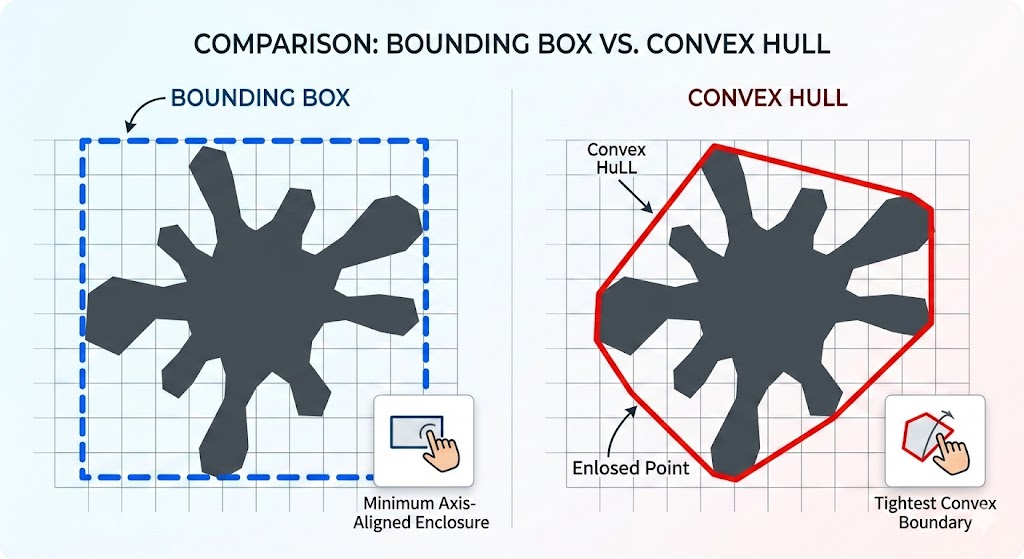



Μέσω ενός featurecollection μπορούμε να αντλήσουμε χρήσιμα χαρακτηριστικά του όπως είναι το bounding box ή το convex hull.

In [53]:
# Επιστρέφει το bounding box που περιέχει όλη τη συλλογή
bounds = greece_admin.geometry().bounds()
convexHull = greece_admin.geometry().convexHull()

Map.addLayer(bounds, {'color': 'red'}, 'Bounding Box')

Map.addLayer(convexHull, {'color': 'green'}, 'Convex Hull')
Map

Map(bottom=6561.0, center=[39.01064750994083, 23.005371093750004], controls=(WidgetControl(options=['position'…

## Δημιουργία geometry objects

Για την δημιουργία γεωμετριών στο Google Earth Engine (GEE), ο χρήστης χρησιμοποιεί τις κλάσεις `ee.Geometry.Point`, `ee.Geometry.LineString` και `ee.Geometry.Polygon`.

Τι πρέπει να γνωρίζεις για τις γεωμετρίες:

- Σύστημα Συντεταγμένων: Το GEE χρησιμοποιεί από προεπιλογή το σύστημα WGS84 (EPSG:4326), οπότε οι συντεταγμένες πρέπει να είναι σε δεκαδική μορφή (π.χ. 23.72 αντί για 23° 43').

- Σειρά Long/Lat: Πάντα βάζουμε πρώτα το Γεωγραφικό Μήκος (Longitude) και μετά το Γεωγραφικό Πλάτος (Latitude).

- Κλείσιμο Πολυγώνου: Στο ee.Geometry.Polygon, η λίστα των σημείων πρέπει να είναι μια λίστα μέσα σε λίστα (double brackets [[ ]]) και το τελευταίο σημείο πρέπει να είναι ταυτόσημο με το πρώτο για να "κλείσει" το σχήμα.

In [8]:
# 1. Αρχικοποίηση
Map = geemap.Map()

# Σημείο (Point) - π.χ. κοντά στην Αθήνα
point = ee.Geometry.Point([23.7275, 37.9838])

# Γραμμή (LineString) - π.χ. μια διαδρομή στην Πελοπόννησο
line = ee.Geometry.LineString([
    [22.4303, 37.5089], # Τρίπολη
    [22.1757, 38.0361]  # Καλάβρυτα
])

# Πολύγωνο (Polygon) - π.χ. ένα τρίγωνο στη Θεσσαλία
polygon = ee.Geometry.Polygon([
    [
        [22.413, 39.639], # Λάρισα
        [21.921, 39.555], # Τρίκαλα
        [21.767, 39.364], # Καρδίτσα
        [22.413, 39.639]  # Κλείσιμο πολυγώνου (ίδιο με το πρώτο σημείο)
    ]
])

# 3. Προσθήκη στον χάρτη
Map.addLayer(point, {'color': 'red'}, 'Random Point')
Map.addLayer(line, {'color': 'blue'}, 'Random Line')
Map.addLayer(polygon, {'color': 'green', 'fillColor': 'green'}, 'Random Polygon')

# Κεντράρισμα στην Ελλάδα
Map.setCenter(23.7, 38.2, 7)


Map

Map(center=[38.2, 23.7], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', …

## Features και FeatureCollections

Ωστόσο τα παραπάνω objects διαθέτουν μόνον γεωγραφική πληροφορία, για να ενσωματωθεί και περιγραφική πληροφορία πρέπει να δημιουργηθούν Features και στην συνέχεια FeatureCollections.

In [9]:

# 1. Αρχικοποίηση
Map = geemap.Map()

# --- ΣΗΜΕΙA (POINTS) ---
# Ορισμός των σημείων (Συντεταγμένες: [Longitude, Latitude])
athens_geom = ee.Geometry.Point([23.7275, 37.9838])
patra_geom = ee.Geometry.Point([21.7346, 38.2466])
thess_geom = ee.Geometry.Point([22.9444, 40.6401])

# 3. Μετατροπή των γεωμετριών σε Features με ιδιότητες
athens_feature = ee.Feature(athens_geom, {'name': 'Athens', 'category': 'Capital'})
patra_feature = ee.Feature(patra_geom, {'name': 'Patra', 'category': 'City'})
thess_feature = ee.Feature(thess_geom, {'name': 'Thessaloniki', 'category': 'City'})

# 4. Δημιουργία ενός ενιαίου FeatureCollection με όλα τα σημεία
point_fc = ee.FeatureCollection([athens_feature, patra_feature, thess_feature])

# --- ΓΡΑΜΜΗ (LINE) ---
line_geom = ee.Geometry.LineString([[22.430, 37.508], [22.175, 38.036]])
line_feature = ee.Feature(line_geom, {'name': 'Γραμμή στην Πελοπόννησο', 'category': 'Road'})
line_fc = ee.FeatureCollection([line_feature])

# --- ΠΟΛΥΓΩΝΟ (POLYGON) ---
poly_geom = ee.Geometry.Polygon([[[22.41, 39.63], [21.92, 39.55], [21.76, 39.36], [22.41, 39.63]]])
poly_feature = ee.Feature(poly_geom, {'name': 'Πολύγωνο στην Θεσσαλία', 'category': 'Land Cover'})
poly_fc = ee.FeatureCollection([poly_feature])

# 2. Προσθήκη στον χάρτη
Map.addLayer(point_fc, {'color': 'red'}, 'Point FC')
Map.addLayer(line_fc, {'color': 'blue'}, 'Line FC')
Map.addLayer(poly_fc, {'color': 'green'}, 'Polygon FC')

# 3. Κεντράρισμα στην Ελλάδα
Map.setCenter(23.0, 38.5, 7)

Map

Map(center=[38.5, 23.0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', …

# Χωρικές σχέσεις και διαδικασίες

## Κεντροειδές (centroid)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!-- Created with Inkscape (http://www.inkscape.org/) -->

<svg
   version="1.1"
   id="svg1"
   xml:space="preserve"
   width="331.86691"
   height="80.822632"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:svg="http://www.w3.org/2000/svg"><defs
     id="defs1" /><sodipodi:namedview
     id="namedview1"
     pagecolor="#ffffff"
     bordercolor="#666666"
     borderopacity="1.0"
     inkscape:showpageshadow="2"
     inkscape:pageopacity="0.0"
     inkscape:pagecheckerboard="0"
     inkscape:deskcolor="#d1d1d1" /><inkscape:clipboard
     min="252.88748,305.14252"
     max="584.7544,385.96516"
     geom-min="253.4439,305.64316"
     geom-max="584.25214,385.45858" /><g
     id="g1"
     transform="matrix(3.7795276,0,0,3.7795276,-329.24083,-307.67894)"><text
       xml:space="preserve"
       style="font-size:21.7423px;line-height:1.25;font-family:'Bitstream Vera Serif';-inkscape-font-specification:'Bitstream Vera Serif, Bold';text-decoration-color:#000000;letter-spacing:0px;word-spacing:0px;fill:#ff0000;stroke-width:0.203835;-inkscape-stroke:none;stop-color:#000000"
       x="123.26638"
       y="99.242722"
       id="text2"><tspan
         sodipodi:role="line"
         id="tspan2"
         style="font-size:21.7423px;fill:#ff0000;stroke:#1a1a1a;stroke-width:0.203835"
         x="123.26638"
         y="99.242722">=</tspan></text><path
       style="fill:#ffcc00;stroke:#000000;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 87.258853,89.488689 c 1.409213,0.61801 3.148345,-0.41007 2.736207,-2.060551 0.03883,-1.474105 -1.083147,-2.95695 -1.196772,-4.184412 1.555729,-1.899559 4.281493,-1.957649 6.477559,-1.391154 2.150673,0.487005 4.174467,1.390809 6.292093,1.989161 2.52629,2.993458 5.54113,6.022803 9.54883,6.770928 1.77432,-0.06594 3.74365,0.31753 4.93035,1.765206 1.69778,2.051338 1.81841,4.971902 1.29809,7.47291 -0.31197,1.379843 -1.47934,2.621903 -2.96789,2.575543 -2.79261,0.0431 -5.35545,-1.75776 -8.17078,-1.31985 -2.5528,1.80758 -6.251128,2.12442 -8.958094,0.47354 -1.304708,-0.81659 -2.091069,-2.323078 -2.102772,-3.852408 1.043574,-0.921315 1.932851,-2.657113 0.875659,-3.887623 -1.153585,-1.225341 -3.061359,-0.795372 -4.352897,-0.03388 -1.089525,0.433812 -2.500963,1.131837 -3.580201,0.326569 -1.059462,-1.232376 -0.723918,-3.134558 -0.829382,-4.643975 z"
       id="path243" /><g
       id="g3"
       transform="translate(0,1.4611395)"><path
         style="fill:#ffcc00;stroke:#000000;stroke-width:0.264583px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
         d="m 144.42675,88.02755 c 1.40921,0.61801 3.14834,-0.41007 2.73621,-2.060551 0.0388,-1.474105 -1.08315,-2.95695 -1.19678,-4.184412 1.55573,-1.899559 4.2815,-1.957649 6.47756,-1.391154 2.15068,0.487005 4.17447,1.390809 6.2921,1.989161 2.52629,2.993458 5.54113,6.022803 9.54883,6.770928 1.77432,-0.06594 3.74365,0.31753 4.93035,1.765206 1.69778,2.051338 1.81841,4.971902 1.29809,7.47291 -0.31197,1.37984 -1.47934,2.621902 -2.96789,2.575542 -2.79261,0.0431 -5.35545,-1.757756 -8.17078,-1.319853 -2.5528,1.807583 -6.25113,2.124423 -8.9581,0.473543 -1.30471,-0.816589 -2.09107,-2.323077 -2.10277,-3.852407 1.04357,-0.921315 1.93285,-2.657113 0.87566,-3.887623 -1.15359,-1.225341 -3.06136,-0.795372 -4.3529,-0.03388 -1.08952,0.433812 -2.50096,1.131837 -3.5802,0.326569 -1.05946,-1.232376 -0.72392,-3.134558 -0.82938,-4.643975 z"
         id="path243-5" /><circle
         inkscape:label="centroid-dot-ae6bbd"
         fill="#ff0000"
         r="2"
         cx="159.43709"
         cy="91.558327"
         id="circle2"
         style="stroke:#1a1a1a;stroke-width:0.2;stroke-dasharray:none" /></g></g></svg>


Σε αρκετές περιπτώσεις είναι χρήσιμος ο υπολογισμός των κεντροειδών σε ένα πολυγωνικό Featurecollection.

Για παράδειγμα, στο πολυγωνικό Featurecollection με τις στατιστικές μονάδες NUTS2 (**nuts_level2**) μπορούμε να υπολογίσουμε τα κεντροειδή ως εξής:

In [ ]:
def add_centroid(feature):
    """ορισμός του feature geometry στο κεντροειδές του"""
    centroid = feature.geometry().centroid() # υπολογισμός του centroid, επιστρέφει ένα σημείο (point)
    feature = feature.setGeometry(centroid) # ενημέρωση της γεωμετρίας του feature με το centroid
    return feature


# loop στο collection για να προσθέσουμε το centroid σε κάθε feature
nuts_level2_centroids = nuts_level2.map(add_centroid)

# εναλλακτικά, μπορούμε να το κάνουμε με μία γραμμή κώδικα χωρίς να ορίσουμε ξεχωριστή συνάρτηση μόνο με την χρήση lambda function
#centroids = nuts_level2.map(lambda feature: feature.setGeometry(feature.geometry().centroid()))


# 1. Αρχικοποίηση
Map = geemap.Map()
Map.addLayer(nuts_level2, {'color': 'green'}, 'Nuts2')
Map.addLayer(nuts_level2_centroids, {'color': 'red'}, 'Nuts2 Centroids')

Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], position='topright', transp…

## Υπολογισμός buffer zone

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!-- Created with Inkscape (http://www.inkscape.org/) -->

<svg
   version="1.1"
   id="svg1"
   xml:space="preserve"
   width="429.67307"
   height="179.08546"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:svg="http://www.w3.org/2000/svg"><defs
     id="defs1" /><sodipodi:namedview
     id="namedview1"
     pagecolor="#ffffff"
     bordercolor="#666666"
     borderopacity="1.0"
     inkscape:showpageshadow="2"
     inkscape:pageopacity="0.0"
     inkscape:pagecheckerboard="0"
     inkscape:deskcolor="#d1d1d1" /><inkscape:clipboard
     min="69.264769,11.117123"
     max="498.93784,190.20258"
     geom-min="69.434974,11.669078"
     geom-max="498.38588,189.65063" /><g
     id="g1"
     transform="matrix(3.7795276,0,0,3.7795276,-145.61811,-13.653539)"><text
       xml:space="preserve"
       style="font-size:15.7994px;line-height:1.25;font-family:'Bitstream Vera Serif';-inkscape-font-specification:'Bitstream Vera Serif, Bold';text-decoration-color:#000000;letter-spacing:0px;word-spacing:0px;fill:#ff0000;stroke-width:0.14812;-inkscape-stroke:none;stop-color:#000000"
       x="89.085434"
       y="35.306915"
       id="text2"><tspan
         sodipodi:role="line"
         id="tspan2"
         style="font-size:15.7994px;fill:#ff0000;stroke:#1a1a1a;stroke-width:0.14812"
         x="89.085434"
         y="35.306915">=</tspan></text><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 64.684609,15.923544 a 1.7136678,1.7136678 0 0 1 -1.713669,1.713668 1.7136678,1.7136678 0 0 1 -1.713667,-1.713668 1.7136678,1.7136678 0 0 1 1.713667,-1.713667 1.7136678,1.7136678 0 0 1 1.713669,1.713667 z"
       id="path241-72-0" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 58.070025,31.533961 a 1.7136678,1.7136678 0 0 1 -1.713669,1.713668 1.7136678,1.7136678 0 0 1 -1.713667,-1.713668 1.7136678,1.7136678 0 0 1 1.713667,-1.713667 1.7136678,1.7136678 0 0 1 1.713669,1.713667 z"
       id="path241-72-9" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 43.517942,45.292294 a 1.7136678,1.7136678 0 0 1 -1.713669,1.713668 1.7136678,1.7136678 0 0 1 -1.713667,-1.713668 1.7136678,1.7136678 0 0 1 1.713667,-1.713667 1.7136678,1.7136678 0 0 1 1.713669,1.713667 z"
       id="path241-72-91" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 64.960911,45.056096 a 1.7136678,1.7136678 0 0 1 -1.713669,1.713668 1.7136678,1.7136678 0 0 1 -1.713667,-1.713668 1.7136678,1.7136678 0 0 1 1.713667,-1.713667 1.7136678,1.7136678 0 0 1 1.713669,1.713667 z"
       id="path241-72-1" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 71.563775,28.358961 a 1.7136678,1.7136678 0 0 1 -1.713669,1.713668 1.7136678,1.7136678 0 0 1 -1.713667,-1.713668 1.7136678,1.7136678 0 0 1 1.713667,-1.713667 1.7136678,1.7136678 0 0 1 1.713669,1.713667 z"
       id="path241-72-7" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="M 49.074192,9.838127 A 1.7136678,1.7136678 0 0 1 47.360523,11.551795 1.7136678,1.7136678 0 0 1 45.646856,9.838127 1.7136678,1.7136678 0 0 1 47.360523,8.12446 1.7136678,1.7136678 0 0 1 49.074192,9.838127 Z"
       id="path241-72-6" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 42.000495,25.325887 a 1.7136678,1.7136678 0 0 1 -1.713669,1.713668 1.7136678,1.7136678 0 0 1 -1.713667,-1.713668 1.7136678,1.7136678 0 0 1 1.713667,-1.713667 1.7136678,1.7136678 0 0 1 1.713669,1.713667 z"
       id="path241-72" /><path
       style="fill:#ffcc00;stroke:#1a1a1a;stroke-width:0.292076"
       d="m 145.18725,15.923543 a 5.5571953,5.5571953 0 0 1 -5.5572,5.557196 5.5571953,5.5571953 0 0 1 -5.5572,-5.557196 5.5571953,5.5571953 0 0 1 5.5572,-5.557193 5.5571953,5.5571953 0 0 1 5.5572,5.557193 z"
       id="path241-72-94-1" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 141.34372,15.923544 a 1.7136678,1.7136678 0 0 1 -1.71367,1.713668 1.7136678,1.7136678 0 0 1 -1.71366,-1.713668 1.7136678,1.7136678 0 0 1 1.71366,-1.713667 1.7136678,1.7136678 0 0 1 1.71367,1.713667 z"
       id="path241-72-0-9" /><path
       style="fill:#ffcc00;stroke:#1a1a1a;stroke-width:0.292076"
       d="m 138.57267,31.53396 a 5.5571953,5.5571953 0 0 1 -5.5572,5.557196 5.5571953,5.5571953 0 0 1 -5.5572,-5.557196 5.5571953,5.5571953 0 0 1 5.5572,-5.557193 5.5571953,5.5571953 0 0 1 5.5572,5.557193 z"
       id="path241-72-94-7" /><path
       style="fill:#ffcc00;stroke:#1a1a1a;stroke-width:0.292076"
       d="m 122.47893,25.688908 a 5.5571953,5.5571953 0 0 1 -5.5572,5.557196 5.5571953,5.5571953 0 0 1 -5.5572,-5.557196 5.5571953,5.5571953 0 0 1 5.5572,-5.557193 5.5571953,5.5571953 0 0 1 5.5572,5.557193 z"
       id="path241-72-94-75" /><path
       style="fill:#ffcc00;stroke:#1a1a1a;stroke-width:0.292076"
       d="m 124.02059,45.292293 a 5.5571953,5.5571953 0 0 1 -5.5572,5.557196 5.5571953,5.5571953 0 0 1 -5.5572,-5.557196 5.5571953,5.5571953 0 0 1 5.5572,-5.557193 5.5571953,5.5571953 0 0 1 5.5572,5.557193 z"
       id="path241-72-94-17" /><path
       style="fill:#ffcc00;stroke:#1a1a1a;stroke-width:0.292076"
       d="m 145.46355,45.056095 a 5.5571953,5.5571953 0 0 1 -5.5572,5.557196 5.5571953,5.5571953 0 0 1 -5.5572,-5.557196 5.5571953,5.5571953 0 0 1 5.5572,-5.557193 5.5571953,5.5571953 0 0 1 5.5572,5.557193 z"
       id="path241-72-94-41" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 134.72914,31.533961 a 1.7136678,1.7136678 0 0 1 -1.71367,1.713668 1.7136678,1.7136678 0 0 1 -1.71367,-1.713668 1.7136678,1.7136678 0 0 1 1.71367,-1.713667 1.7136678,1.7136678 0 0 1 1.71367,1.713667 z"
       id="path241-72-9-3" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 120.17706,45.292294 a 1.7136678,1.7136678 0 0 1 -1.71367,1.713668 1.7136678,1.7136678 0 0 1 -1.71367,-1.713668 1.7136678,1.7136678 0 0 1 1.71367,-1.713667 1.7136678,1.7136678 0 0 1 1.71367,1.713667 z"
       id="path241-72-91-9" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 141.62002,45.056096 a 1.7136678,1.7136678 0 0 1 -1.71366,1.713668 1.7136678,1.7136678 0 0 1 -1.71367,-1.713668 1.7136678,1.7136678 0 0 1 1.71367,-1.713667 1.7136678,1.7136678 0 0 1 1.71366,1.713667 z"
       id="path241-72-1-0" /><path
       style="fill:#ffcc00;stroke:#1a1a1a;stroke-width:0.292076"
       d="m 152.06642,28.35896 a 5.5571953,5.5571953 0 0 1 -5.5572,5.557196 5.5571953,5.5571953 0 0 1 -5.5572,-5.557196 5.5571953,5.5571953 0 0 1 5.5572,-5.557193 5.5571953,5.5571953 0 0 1 5.5572,5.557193 z"
       id="path241-72-94-4" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 148.22289,28.358961 a 1.7136678,1.7136678 0 0 1 -1.71367,1.713668 1.7136678,1.7136678 0 0 1 -1.71367,-1.713668 1.7136678,1.7136678 0 0 1 1.71367,-1.713667 1.7136678,1.7136678 0 0 1 1.71367,1.713667 z"
       id="path241-72-7-8" /><path
       style="fill:#ffcc00;stroke:#1a1a1a;stroke-width:0.292076"
       d="m 129.14325,9.3157298 a 5.5571953,5.5571953 0 0 1 -5.5572,5.5571962 5.5571953,5.5571953 0 0 1 -5.5572,-5.5571962 5.5571953,5.5571953 0 0 1 5.5572,-5.557193 5.5571953,5.5571953 0 0 1 5.5572,5.557193 z"
       id="path241-72-94" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 125.29972,9.3157309 a 1.7136678,1.7136678 0 0 1 -1.71367,1.7136681 1.7136678,1.7136678 0 0 1 -1.71367,-1.7136681 1.7136678,1.7136678 0 0 1 1.71367,-1.713667 1.7136678,1.7136678 0 0 1 1.71367,1.713667 z"
       id="path241-72-6-8" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 118.65961,25.325887 a 1.7136678,1.7136678 0 0 1 -1.71367,1.713668 1.7136678,1.7136678 0 0 1 -1.71367,-1.713668 1.7136678,1.7136678 0 0 1 1.71367,-1.713667 1.7136678,1.7136678 0 0 1 1.71367,1.713667 z"
       id="path241-72-5" /></g></svg>


Κατά την χωρική ανάλυση, υπάρχουν διαδικασίες που απαιτούν τον υπολογισμό περιμετρικών ζωνών γύρω από χωρικά αντικείμενα. Στο google earth engine ο υπολογισμός γίνεται κάνοντας ένα βρόγχο πάνω στα features ενός featurecollection και για κάθε feature λαμβάνουμε την γεωμετρία του και στην συνέχεια υπολογίζουμε το buffer επί αυτής. Το buffer λαμβάνει σαν παράμετρο την ακτίνα που θα έχει αυτή η περιμετρική ζώνη γύρω από την γεωμετρία.

In [6]:
# Ορισμός της απόστασης buffer σε μέτρα
buffer_distance = 5000 

# loop στο collection για να προσθέσουμε το buffer σε κάθε centroid
buffered_centroids = nuts_level2_centroids.map(lambda feature: 
    feature.setGeometry(feature.geometry().buffer(buffer_distance))
)

# προσθήκη στον χάρτη
Map.addLayer(buffered_centroids, {'color': 'blue'}, f'Nuts2 buffer ({buffer_distance} m)')

## Απλοποίηση γεωμετρίας (simplification)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!-- Created with Inkscape (http://www.inkscape.org/) -->

<svg
   version="1.1"
   id="svg1"
   xml:space="preserve"
   width="666.99792"
   height="84.342117"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:svg="http://www.w3.org/2000/svg"><defs
     id="defs1"><marker
       style="overflow:visible"
       id="Dot"
       refX="0"
       refY="0"
       orient="auto"
       inkscape:stockid="Dot"
       markerWidth="0.80000001"
       markerHeight="0.80000001"
       viewBox="0 0 1 1"
       inkscape:isstock="true"
       inkscape:collect="always"
       preserveAspectRatio="xMidYMid"><path
         transform="scale(0.5)"
         style="fill:context-stroke;fill-rule:evenodd;stroke:none"
         d="M 5,0 C 5,2.76 2.76,5 0,5 -2.76,5 -5,2.76 -5,0 c 0,-2.76 2.3,-5 5,-5 2.76,0 5,2.24 5,5 z"
         sodipodi:nodetypes="sssss"
         id="path17" /></marker><marker
       style="overflow:visible"
       id="marker1"
       refX="0"
       refY="0"
       orient="auto"
       inkscape:stockid="Dot"
       markerWidth="0.80000001"
       markerHeight="0.80000001"
       viewBox="0 0 1 1"
       inkscape:isstock="true"
       inkscape:collect="always"
       preserveAspectRatio="xMidYMid"><path
         transform="scale(0.5)"
         style="fill:context-stroke;fill-rule:evenodd;stroke:none"
         d="M 5,0 C 5,2.76 2.76,5 0,5 -2.76,5 -5,2.76 -5,0 c 0,-2.76 2.3,-5 5,-5 2.76,0 5,2.24 5,5 z"
         sodipodi:nodetypes="sssss"
         id="path1" /></marker></defs><sodipodi:namedview
     id="namedview1"
     pagecolor="#ffffff"
     bordercolor="#666666"
     borderopacity="1.0"
     inkscape:showpageshadow="2"
     inkscape:pageopacity="0.0"
     inkscape:pagecheckerboard="0"
     inkscape:deskcolor="#d1d1d1" /><inkscape:clipboard
     min="87.615121,429.8853"
     max="754.61304,514.22742"
     geom-min="88.204615,433.943"
     geom-max="750.54783,513.33398" /><g
     id="g1"
     transform="matrix(3.7795276,0,0,3.7795276,-163.96847,-432.42172)"><text
       xml:space="preserve"
       style="font-size:21.7423px;line-height:1.25;font-family:'Bitstream Vera Serif';-inkscape-font-specification:'Bitstream Vera Serif, Bold';text-decoration-color:#000000;letter-spacing:0px;word-spacing:0px;fill:#ff0000;stroke-width:0.203835;-inkscape-stroke:none;stop-color:#000000"
       x="126.71186"
       y="132.38504"
       id="text2"><tspan
         sodipodi:role="line"
         id="tspan2"
         style="font-size:21.7423px;fill:#ff0000;stroke:#1a1a1a;stroke-width:0.203835"
         x="126.71186"
         y="132.38504">=</tspan></text><path
       style="font-variation-settings:normal;opacity:1;vector-effect:none;fill:#ffd42a;fill-opacity:1;stroke:#000000;stroke-width:0.537679px;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:4;stroke-dasharray:none;stroke-dashoffset:0;stroke-opacity:1;-inkscape-stroke:none;marker-mid:url(#Dot);stop-color:#000000;stop-opacity:1"
       d="m 43.539293,133.82336 2.809081,-2.00088 0.191716,-4.33413 3.768643,1.74131 1.232675,2.92658 6.001585,1.00026 1.000263,-3.33422 3.334218,-2.00052 -0.707823,3.06176 1.708086,2.93984 3.667632,-1.00028 v -3.66764 l 5.668166,-1.33368 0.333421,3.66764 4.006506,-1.01594 4.662451,3.01646 1.199185,-3.59755 0.80134,-2.40402 0.241452,-6.52076 4.759867,-5.48241 -0.333422,8.33554 2.333954,4.00104 5.001316,1.33368 4.334481,-6.00156 2.333944,3.66763 3.77284,3.43251 5.37655,-0.53137 5.18774,2.43359 -8.00212,4.33447"
       id="path247"
       sodipodi:nodetypes="ccccccccccccccccccccccccccccc" /><path
       style="fill:#ffd42a;stroke:#000000;stroke-width:0.537679px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1;marker-mid:url(#Dot)"
       d="m 147.95388,132.68585 c 2.71732,-5.88872 6.76596,-5.61879 9.92487,-0.93496 4.11867,0.24049 8.42788,-6.99083 9.42188,0.11932 4.52564,-0.51025 7.57825,-9.13237 12.09173,-1.9488 12.02533,5.86898 4.62754,-11.48017 12.65069,-13.30508 -2.03415,8.67833 7.17656,14.04906 12.24132,7.47206 3.59279,5.4393 10.19982,3.85754 14.4999,6.78564 -0.88412,2.52272 -3.97698,3.40581 -6.14665,4.47913"
       id="path247-9" /></g></svg>


Στο Google Earth Engine, η απλοποίηση (simplification) είναι η διαδικασία μείωσης του αριθμού των κορυφών (vertices) ενός πολυγώνου ή γραμμής, ενώ παράλληλα επιχειρείται η διατήρηση του γενικού του σχήματος. Αυτό είναι καθοριστικό για τη βελτίωση της απόδοσης, τη μείωση του μεγέθους αποθήκευσης και την επιτάχυνση των χωρικών συζεύξεων (spatial joins) ή των εξαγωγών (exports).

Το Earth Engine χρησιμοποιεί τον αλγόριθμο Douglas-Peucker για την απλοποίηση. Αυτός ο αλγόριθμος εξαλείφει σημεία που βρίσκονται εντός μιας καθορισμένης απόστασης (το maxError) από ένα τμήμα γραμμής μεταξύ δύο άλλων σημείων.
Τα πλεονεκτήματα της απλοποίησης συνοψίζονται ως εξής:

- Ταχύτερη Απεικόνιση: Λιγότερες κορυφές σημαίνουν ότι ο client και ο server μπορούν να σχεδιάσουν τα σχήματα πιο γρήγορα.

- Μείωση Μνήμης: Πολύπλοκες γεωμετρίες (όπως ακτογραμμές ή διοικητικά όρια υψηλής ανάλυσης) μπορεί μερικές φορές να φτάσουν τα όρια μνήμης κατά την επεξεργασία.

- Καθαρότερα Buffers: Εάν δημιουργήσετε buffer σε ένα σύνθετο πολύγωνο, η γεωμετρία που προκύπτει μπορεί να γίνει εκθετικά πιο περίπλοκη. Η απλοποίηση πριν από το buffer βοηθά στη διατήρηση των δεδομένων σε διαχειρίσιμο επίπεδο.

Για να απλοποιήθεί μια FeatureCollection, εφαρμόζετε η μέθοδος .simplify() πάνω στις γεωμετρίες χρησιμοποιώντας τη συνάρτηση map. Η πιο σημαντική παράμετρος είναι το maxError, το οποίο ορίζεται σε μέτρα.

Προσοχή απαιτείται στην επιλογή του maxError. Μεγάλες τιμές μπορεί να οδηγήσουν σε πολύ γενικευμένα σχήματα και να δημιουργήσουν κενά ανάμεσα σε κοινά όρια πολυγώνων (silver polygons). Ανάλογα την κλίμακα εργασίας λαμβάνει τιμές και η παράμετρος maxError.

In [7]:
# Απλοποίηση της γεωμετρίας NUTS2 χρησιμοποιώντας τον αλγόριθμο Douglas-Peucker
# maxError ορίζεται σε μέτρα 

# Ορισμός simplification tolerance (σε μέτρα)
# Υψηλή τιμή = λιγότεροι κόμβοι = ποιο "χοντροκομμένο" σχήμα στην γεωμετρία

maxError = 100
simplified_nuts = nuts_level2.map(lambda feature: 
    feature.setGeometry(feature.geometry().simplify(maxError=maxError))
)

# Προσθήκη στον χάρτη
Map.addLayer(simplified_nuts, {'color': 'purple'}, f'NUTS2 simplified ({maxError}m)')





# Τομή (Intersection)


<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!-- Created with Inkscape (http://www.inkscape.org/) -->

<svg
   version="1.1"
   id="svg1"
   xml:space="preserve"
   width="328.26163"
   height="127.76379"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:svg="http://www.w3.org/2000/svg"><defs
     id="defs1" /><sodipodi:namedview
     id="namedview1"
     pagecolor="#ffffff"
     bordercolor="#666666"
     borderopacity="1.0"
     inkscape:showpageshadow="2"
     inkscape:pageopacity="0.0"
     inkscape:pagecheckerboard="0"
     inkscape:deskcolor="#d1d1d1" /><inkscape:clipboard
     min="1.8162673e-06,0.0071097643"
     max="328.26162,127.77089"
     geom-min="0.47336045,0.47648721"
     geom-max="327.78827,127.29754" /><g
     id="g1"
     transform="matrix(3.7795276,0,0,3.7795276,-76.353346,-2.5435258)"><g
       id="g2"
       transform="matrix(0.55982321,0,0,0.55982321,8.8923734,0.29622768)"><rect
         style="fill:#ff2a2a;stroke:#1a1a1a;stroke-width:0.785184;-inkscape-stroke:none"
         id="rect1"
         width="25.506222"
         height="25.506222"
         x="40.033997"
         y="21.935562" /><circle
         style="opacity:0.722737;fill:#008000;stroke:#1a1a1a;stroke-width:0.447437;-inkscape-stroke:none"
         id="path1"
         cx="69.102531"
         cy="34.456642"
         r="8.5131874" /><circle
         style="opacity:0.722737;fill:#008000;stroke:#1a1a1a;stroke-width:0.447437;-inkscape-stroke:none"
         id="path1-9"
         cx="51.343155"
         cy="21.766594"
         r="8.5131874" /><circle
         style="opacity:0.722737;fill:#008000;stroke:#1a1a1a;stroke-width:0.447437;-inkscape-stroke:none"
         id="path1-0"
         cx="32.549404"
         cy="12.441072"
         r="8.5131874" /><circle
         style="opacity:0.722737;fill:#008000;stroke:#1a1a1a;stroke-width:0.447437;-inkscape-stroke:none"
         id="path1-06"
         cx="28.938728"
         cy="34.401489"
         r="8.5131874" /><circle
         style="opacity:0.722737;fill:#008000;stroke:#1a1a1a;stroke-width:0.447437;-inkscape-stroke:none"
         id="path1-8"
         cx="37.018932"
         cy="52.319717"
         r="8.5131874" /><circle
         style="opacity:0.722737;fill:#008000;stroke:#1a1a1a;stroke-width:0.447437;-inkscape-stroke:none"
         id="path1-02"
         cx="55.865288"
         cy="51.318157"
         r="8.5131874" /></g><rect
       style="fill:#ff2a2a;stroke:#1a1a1a;stroke-width:0.439564;-inkscape-stroke:none"
       id="rect1-4"
       width="14.278975"
       height="14.278975"
       x="85.890007"
       y="10.87828" /><circle
       style="opacity:0.722737;fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
       id="path1-5"
       cx="102.16325"
       cy="17.887871"
       r="4.7658801" /><circle
       style="opacity:0.722737;fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
       id="path1-9-0"
       cx="92.221138"
       cy="10.783688"
       r="4.7658801" /><circle
       style="font-variation-settings:normal;opacity:0.722737;vector-effect:none;fill:#f9f9f9;fill-opacity:1;stroke:#1a1a1a;stroke-width:0.250486;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:4;stroke-dasharray:0.250486, 0.250486;stroke-dashoffset:0;stroke-opacity:1;-inkscape-stroke:none;stop-color:#000000;stop-opacity:1"
       id="path1-0-3"
       cx="81.699966"
       cy="5.5630441"
       r="4.7658801" /><circle
       style="font-variation-settings:normal;opacity:0.722737;vector-effect:none;fill:#f9f9f9;fill-opacity:1;stroke:#1a1a1a;stroke-width:0.250486;stroke-linecap:butt;stroke-linejoin:miter;stroke-miterlimit:4;stroke-dasharray:0.250486, 0.250486;stroke-dashoffset:0;stroke-opacity:1;-inkscape-stroke:none;stop-color:#000000;stop-opacity:1"
       id="path1-06-6"
       cx="79.678627"
       cy="17.856995"
       r="4.7658801" /><circle
       style="opacity:0.722737;fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
       id="path1-8-1"
       cx="84.20211"
       cy="27.888035"
       r="4.7658801" /><circle
       style="opacity:0.722737;fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
       id="path1-02-0"
       cx="94.752731"
       cy="27.327337"
       r="4.7658801" /><text
       xml:space="preserve"
       style="font-size:15.7994px;line-height:1.25;font-family:'Bitstream Vera Serif';-inkscape-font-specification:'Bitstream Vera Serif, Bold';text-decoration-color:#000000;letter-spacing:0px;word-spacing:0px;fill:#ff0000;stroke-width:0.14812;-inkscape-stroke:none;stop-color:#000000"
       x="57.993244"
       y="23.937386"
       id="text2"><tspan
         sodipodi:role="line"
         id="tspan2"
         style="font-size:15.7994px;fill:#ff0000;stroke:#1a1a1a;stroke-width:0.14812"
         x="57.993244"
         y="23.937386">=</tspan></text></g></svg>


In [14]:
# Φόρτωση των δεδομένων WDPA
wdpa = ee.FeatureCollection("WCMC/WDPA/current/polygons")


greece_protected_areas= wdpa.filterBounds(greece_admin.geometry()) # https://developers.google.com/earth-engine/apidocs/ee-featurecollection-filterbounds


Map = geemap.Map()
Map.addLayer(greece_protected_areas, {'color': 'brown'}, f'Protected Areas (intersection)')
Map.addLayer(greece_admin.geometry(), {'color': 'blue'}, f'greece_admin.geometry')

Map.centerObject(greece_protected_areas.bounds(), 6)

Map

Map(center=[38.49208657317836, 24.500466070815737], controls=(WidgetControl(options=['position', 'transparent_…

# Clip (αποκοπή)

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!-- Created with Inkscape (http://www.inkscape.org/) -->

<svg
   version="1.1"
   id="svg1"
   xml:space="preserve"
   width="278.12964"
   height="121.35019"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:svg="http://www.w3.org/2000/svg"><defs
     id="defs1"><clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath26"><rect
         style="opacity:0.724348;fill:#ff2a2a;stroke:#1a1a1a;stroke-width:0.439563;-inkscape-stroke:none"
         id="rect26"
         width="14.278975"
         height="14.278975"
         x="31.304335"
         y="12.576264" /></clipPath><clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath25"><rect
         style="opacity:0.724348;fill:#ff2a2a;stroke:#1a1a1a;stroke-width:0.439563;-inkscape-stroke:none"
         id="rect25"
         width="14.278975"
         height="14.278975"
         x="31.304335"
         y="12.576264" /></clipPath><clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath22"><rect
         style="opacity:0.724348;fill:#ff2a2a;stroke:#1a1a1a;stroke-width:0.439563;-inkscape-stroke:none"
         id="rect22"
         width="14.278975"
         height="14.278975"
         x="31.304335"
         y="12.576264" /></clipPath><clipPath
       clipPathUnits="userSpaceOnUse"
       id="clipPath21"><rect
         style="opacity:0.724348;fill:#ff2a2a;stroke:#1a1a1a;stroke-width:0.439563;-inkscape-stroke:none"
         id="rect21"
         width="14.278975"
         height="14.278975"
         x="31.304335"
         y="12.576264" /></clipPath></defs><sodipodi:namedview
     id="namedview1"
     pagecolor="#ffffff"
     bordercolor="#666666"
     borderopacity="1.0"
     inkscape:showpageshadow="2"
     inkscape:pageopacity="0.0"
     inkscape:pagecheckerboard="0"
     inkscape:deskcolor="#d1d1d1" /><inkscape:clipboard
     min="-8.4596223e-09,6.4207078"
     max="278.12964,127.77089"
     geom-min="0.47335934,6.8940672"
     geom-max="303.6798,131.58653" /><g
     id="g1"
     transform="matrix(3.7795276,0,0,3.7795276,-76.353344,-8.9571239)"><circle
       style="opacity:1;fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
       id="path1"
       r="4.7658801"
       cy="19.585855"
       cx="47.577576" /><circle
       style="opacity:1;fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
       id="path1-9"
       r="4.7658801"
       cy="12.481672"
       cx="37.635464" /><circle
       style="opacity:1;fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
       id="path1-0"
       r="4.7658801"
       cy="7.2610288"
       cx="27.114285" /><circle
       style="opacity:1;fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
       id="path1-06"
       r="4.7658801"
       cy="19.554979"
       cx="25.092945" /><circle
       style="opacity:1;fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
       id="path1-8"
       r="4.7658801"
       cy="29.58602"
       cx="29.61643" /><circle
       style="opacity:1;fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
       id="path1-02"
       r="4.7658801"
       cy="29.025324"
       cx="40.167057" /><text
       xml:space="preserve"
       style="font-size:15.7994px;line-height:1.25;font-family:'Bitstream Vera Serif';-inkscape-font-specification:'Bitstream Vera Serif, Bold';text-decoration-color:#000000;letter-spacing:0px;word-spacing:0px;fill:#ff0000;stroke-width:0.14812;-inkscape-stroke:none;stop-color:#000000"
       x="57.993244"
       y="23.937386"
       id="text2"><tspan
         sodipodi:role="line"
         id="tspan2"
         style="font-size:15.7994px;fill:#ff0000;stroke:#1a1a1a;stroke-width:0.14812"
         x="57.993244"
         y="23.937386">=</tspan></text><rect
       style="opacity:0.724348;fill:#ff2a2a;stroke:#1a1a1a;stroke-width:0.439564;-inkscape-stroke:none"
       id="rect1"
       width="14.278975"
       height="14.278975"
       x="31.304335"
       y="12.576264" /><g
       id="g26"
       transform="translate(0.57199528,2.1920498)"><circle
         style="fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
         id="path1-5"
         r="4.7658801"
         cy="19.585855"
         cx="47.577576"
         clip-path="url(#clipPath26)"
         transform="translate(47.634986,-1.0572543)" /><circle
         style="fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
         id="path1-9-6"
         r="4.7658801"
         cy="12.481672"
         cx="37.635464"
         clip-path="url(#clipPath25)"
         transform="translate(47.634986,-1.0572543)" /><circle
         style="fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
         id="path1-8-7"
         r="4.7658801"
         cy="29.58602"
         cx="29.61643"
         clip-path="url(#clipPath22)"
         transform="translate(47.634986,-1.0572543)" /><circle
         style="fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
         id="path1-02-4"
         r="4.7658801"
         cy="29.025324"
         cx="40.167057"
         clip-path="url(#clipPath21)"
         transform="translate(47.634986,-1.0572543)" /></g></g></svg>


In [15]:
# 2. Φιλτράρισμα (για ταχύτητα) και στη συνέχεια Clip
# Χρησιμοποιούμε τη map για να εφαρμόσουμε το intersection σε κάθε πολύγωνο
clipped_wdpa = wdpa.filterBounds(greece_admin.geometry()).map(lambda feature: 
    feature.intersection(greece_admin.geometry(), ee.ErrorMargin(1))
)
Map.addLayer(clipped_wdpa, {'color': 'Blue'}, f'Protected Areas (Clip)')


# Συγκόλληση (Dissolve)

Στο Google Earth Engine, η λειτουργία "dissolve" (σύμπτυξη) πραγματοποιείται χρησιμοποιώντας τη μέθοδο .union() σε μια συλλογή FeatureCollection.

Όταν κάνετε dissolve σε στοιχεία, το Earth Engine εξετάζει όλα τα μεμονωμένα πολύγωνα και συγχωνεύει τα όριά τους. Τυχόν κοινά σύνορα μεταξύ γειτονικών προστατευόμενων περιοχών αφαιρούνται, δημιουργώντας ένα ενιαίο ενοποιημένο σχήμα.

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!-- Created with Inkscape (http://www.inkscape.org/) -->

<svg
   version="1.1"
   id="svg1"
   xml:space="preserve"
   width="319.32083"
   height="125.38605"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:svg="http://www.w3.org/2000/svg"><defs
     id="defs1" /><sodipodi:namedview
     id="namedview1"
     pagecolor="#ffffff"
     bordercolor="#666666"
     borderopacity="1.0"
     inkscape:showpageshadow="2"
     inkscape:pageopacity="0.0"
     inkscape:pagecheckerboard="0"
     inkscape:deskcolor="#d1d1d1" /><inkscape:clipboard
     min="7.639708,2.3848426"
     max="326.96055,127.77089"
     geom-min="8.1130674,2.858202"
     geom-max="326.48719,127.29754" /><g
     id="g1"
     transform="matrix(3.7795276,0,0,3.7795276,-83.993052,-4.9212586)"><circle
       style="opacity:1;fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
       id="path1"
       r="4.7658801"
       cy="19.585855"
       cx="47.577576" /><circle
       style="opacity:1;fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
       id="path1-9"
       r="4.7658801"
       cy="16.890266"
       cx="40.8839" /><circle
       style="opacity:1;fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
       id="path1-0"
       r="4.7658801"
       cy="7.2610288"
       cx="27.114285" /><circle
       style="opacity:1;fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
       id="path1-06"
       r="4.7658801"
       cy="24.427635"
       cx="29.73357" /><circle
       style="opacity:1;fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
       id="path1-8"
       r="4.7658801"
       cy="29.58602"
       cx="29.61643" /><circle
       style="opacity:1;fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
       id="path1-02"
       r="4.7658801"
       cy="29.025324"
       cx="37.382683" /><text
       xml:space="preserve"
       style="font-size:15.7994px;line-height:1.25;font-family:'Bitstream Vera Serif';-inkscape-font-specification:'Bitstream Vera Serif, Bold';text-decoration-color:#000000;letter-spacing:0px;word-spacing:0px;fill:#ff0000;stroke-width:0.14812;-inkscape-stroke:none;stop-color:#000000"
       x="57.993244"
       y="23.937386"
       id="text2"><tspan
         sodipodi:role="line"
         id="tspan2"
         style="font-size:15.7994px;fill:#ff0000;stroke:#1a1a1a;stroke-width:0.14812"
         x="57.993244"
         y="23.937386">=</tspan></text><path
       id="path1-3"
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.250486;-inkscape-stroke:none"
       d="M 81.355426,1.427326 A 4.7658801,4.7658801 0 0 0 76.589825,6.1929266 4.7658801,4.7658801 0 0 0 81.355426,10.959044 4.7658801,4.7658801 0 0 0 86.121543,6.1929266 4.7658801,4.7658801 0 0 0 81.355426,1.427326 Z m 13.769702,9.62887 a 4.7658801,4.7658801 0 0 0 -4.765601,4.766116 4.7658801,4.7658801 0 0 0 4.765601,4.766118 4.7658801,4.7658801 0 0 0 2.189013,-0.545187 4.7658801,4.7658801 0 0 0 4.504639,3.240629 4.7658801,4.7658801 0 0 0 4.76611,-4.766117 4.7658801,4.7658801 0 0 0 -4.76611,-4.7656 4.7658801,4.7658801 0 0 0 -2.181266,0.540535 4.7658801,4.7658801 0 0 0 -4.512386,-3.236494 z m -11.150224,7.537523 a 4.7658801,4.7658801 0 0 0 -4.765601,4.766118 4.7658801,4.7658801 0 0 0 0.708484,2.488737 4.7658801,4.7658801 0 0 0 -0.825789,2.669604 4.7658801,4.7658801 0 0 0 4.7656,4.765601 4.7658801,4.7658801 0 0 0 4.079855,-2.318205 4.7658801,4.7658801 0 0 0 3.686596,1.757516 4.7658801,4.7658801 0 0 0 4.766118,-4.765601 4.7658801,4.7658801 0 0 0 -4.766118,-4.766117 4.7658801,4.7658801 0 0 0 -2.977596,1.056783 4.7658801,4.7658801 0 0 0 0.09457,-0.888318 4.7658801,4.7658801 0 0 0 -4.766117,-4.766118 z" /></g></svg>

Στο παρακάτω παράδειγμα γίνεται dissolve όλων των πολύγωνων που ανήκουν στην "Ελλάδα" σε ένα ενιαίο αντικείμενων πολλαπλών μερών (multipart feature):

In [ ]:
# 3. Dissolve (Union) στις γεωμετρίες για να δημιουργήσουμε ένα ενιαίο πολύγωνο

dissolved_greece = greece_admin.union(maxError=1)


# 1. Αρχικοποίηση
Map = geemap.Map()
Map.centerObject(dissolved_greece,6)
Map.addLayer(dissolved_greece, {'color': 'orange'}, f'Greece (Dissolved)')
Map.addLayer(greece_admin, {'color': 'black'}, f'greece_admin', False)
Map

Map(center=[39.01690829195933, 22.99942361730524], controls=(WidgetControl(options=['position', 'transparent_b…

# Διαφορά (Difference) 

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!-- Created with Inkscape (http://www.inkscape.org/) -->

<svg
   version="1.1"
   id="svg1"
   xml:space="preserve"
   width="294.67419"
   height="125.3698"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:svg="http://www.w3.org/2000/svg"><defs
     id="defs1" /><sodipodi:namedview
     id="namedview1"
     pagecolor="#ffffff"
     bordercolor="#666666"
     borderopacity="1.0"
     inkscape:showpageshadow="2"
     inkscape:pageopacity="0.0"
     inkscape:pagecheckerboard="0"
     inkscape:deskcolor="#d1d1d1" /><inkscape:clipboard
     min="7.6397065,6.4207079"
     max="302.31391,131.79051"
     geom-min="8.1130658,6.8940673"
     geom-max="301.84055,131.31715" /><g
     id="g1"
     transform="matrix(3.7795276,0,0,3.7795276,-83.99305,-8.957124)"><path
       id="path1-02"
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.250486"
       d="m 44.236843,30.649542 a 4.7658801,4.7658801 0 0 1 -4.76588,4.76588 4.7658801,4.7658801 0 0 1 -4.765881,-4.76588 4.7658801,4.7658801 0 0 1 4.765881,-4.76588 4.7658801,4.7658801 0 0 1 4.76588,4.76588 z M 33.686216,30.514145 a 4.7658801,4.7658801 0 0 1 -4.76588,4.76588 4.7658801,4.7658801 0 0 1 -4.76588,-4.76588 4.7658801,4.7658801 0 0 1 4.76588,-4.76588 4.7658801,4.7658801 0 0 1 4.76588,4.76588 z m 0.813234,-10.03104 a 4.7658801,4.7658801 0 0 1 -4.76588,4.76588 4.7658801,4.7658801 0 0 1 -4.76588,-4.76588 4.7658801,4.7658801 0 0 1 4.76588,-4.76588 4.7658801,4.7658801 0 0 1 4.76588,4.76588 z M 31.880165,7.2610288 a 4.7658801,4.7658801 0 0 1 -4.76588,4.7658802 4.7658801,4.7658801 0 0 1 -4.765881,-4.7658802 4.7658801,4.7658801 0 0 1 4.765881,-4.7658801 4.7658801,4.7658801 0 0 1 4.76588,4.7658801 z m 12.609459,3.3643932 a 4.7658801,4.7658801 0 0 1 -4.765881,4.76588 4.7658801,4.7658801 0 0 1 -4.76588,-4.76588 4.7658801,4.7658801 0 0 1 4.76588,-4.7658806 4.7658801,4.7658801 0 0 1 4.765881,4.7658806 z m 7.853832,8.960433 a 4.7658801,4.7658801 0 0 1 -4.76588,4.765881 4.7658801,4.7658801 0 0 1 -4.76588,-4.765881 4.7658801,4.7658801 0 0 1 4.76588,-4.76588 4.7658801,4.7658801 0 0 1 4.76588,4.76588 z" /><text
       xml:space="preserve"
       style="font-size:15.7994px;line-height:1.25;font-family:'Bitstream Vera Serif';-inkscape-font-specification:'Bitstream Vera Serif, Bold';text-decoration-color:#000000;letter-spacing:0px;word-spacing:0px;fill:#ff0000;stroke-width:0.14812;-inkscape-stroke:none;stop-color:#000000"
       x="57.993244"
       y="23.937386"
       id="text2"><tspan
         sodipodi:role="line"
         id="tspan2"
         style="font-size:15.7994px;fill:#ff0000;stroke:#1a1a1a;stroke-width:0.14812"
         x="57.993244"
         y="23.937386">=</tspan></text><path
       id="rect1"
       style="opacity:0.724348;fill:#ff2a2a;stroke:#1a1a1a;stroke-width:0.511032"
       inkscape:transform-center-x="61.504542"
       inkscape:transform-center-y="-37.765947"
       d="M 28.599297,12.307221 H 45.199863 V 28.907788 H 28.599297 Z" /><path
       id="path1-02-6"
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.250486"
       d="m 74.834332,2.4951487 a 4.7658801,4.7658801 0 0 0 -4.765601,4.7656006 4.7658801,4.7658801 0 0 0 4.765601,4.7661177 4.7658801,4.7658801 0 0 0 4.766117,-4.7661177 4.7658801,4.7658801 0 0 0 -4.766117,-4.7656006 z m 12.609566,3.3641358 a 4.7658801,4.7658801 0 0 0 -4.765601,4.7661185 4.7658801,4.7658801 0 0 0 0.347783,1.681551 h 8.836153 a 4.7658801,4.7658801 0 0 0 0.347782,-1.681551 4.7658801,4.7658801 0 0 0 -4.766117,-4.7661185 z m 7.853784,8.9606945 a 4.7658801,4.7658801 0 0 0 -2.377633,0.636136 v 8.258928 a 4.7658801,4.7658801 0 0 0 2.377633,0.636653 4.7658801,4.7658801 0 0 0 4.766118,-4.766117 4.7658801,4.7658801 0 0 0 -4.766118,-4.7656 z m -18.97817,1.046447 a 4.7658801,4.7658801 0 0 0 -3.631303,4.616773 4.7658801,4.7658801 0 0 0 3.631303,4.616255 z m 0,9.923942 a 4.7658801,4.7658801 0 0 0 -4.44469,4.723743 4.7658801,4.7658801 0 0 0 4.765601,4.765601 4.7658801,4.7658801 0 0 0 4.766117,-4.765601 4.7658801,4.7658801 0 0 0 -0.316776,-1.60662 h -4.770252 z m 6.478675,3.117123 a 4.7658801,4.7658801 0 0 0 -0.372588,1.742012 4.7658801,4.7658801 0 0 0 4.765601,4.765601 4.7658801,4.7658801 0 0 0 4.766117,-4.765601 4.7658801,4.7658801 0 0 0 -0.373103,-1.742012 z" /></g></svg>


Στο παρακάτω παράδειγμα εντοπίζονται οι μη προστατεύομενες περιοχές στην Μαγνησία. Για τον υπολογισμό:

- από τα διοικητικά όρια της Ελλάδας (greece_admin FeatureCollection), φιλτράρουμε στο property 'ADM2_NAME' ίσο με  'Magnisias'
- φτιάχνουμε ένα geometry object (subtractor_geom) το οποίο προκύπτει από το φιλτάρισμα των προστατευόμενων περιοχών στα όρια της Μαγνησίας. Επιπλέον κάνουμε απλοποίηση της γεωμετρία για καλύτερη απόδοση.
- Για κάθε Feature στην magnisia (που στην περίπτωσή μας είναι 1) εφαρμόζουμε την συνάρτηση **substract_protected_areas**.
- Στην συνάρτηση  **substract_protected_areas** αφαιρούμε από το τρέχον Feature geometry τo subtractor_geom και επιστρέφουμε το Feature με την νέα γεωμετρία. 

In [ ]:

# 
magnisia = greece_admin.filter(ee.Filter.eq('ADM2_NAME', 'Magnisias'))

subtractor_geom = greece_protected_areas.filterBounds(magnisia).geometry().simplify(maxError=100)

def substract_protected_areas(feature):
    # Απλοποίηση της γεωμετρίας του feature για καλύτερη απόδοση (προαιρετικό, εξαρτάται από το μέγεθος και την πολυπλοκότητα των γεωμετριών)
    f_geom = feature.geometry().simplify(maxError=100)
    
    # Υπολογισμός της διαφοράς (difference) με το γεωμετρικό αντικείμενο που θέλουμε να αφαιρέσουμε
    diff_geom = f_geom.difference(subtractor_geom, ee.ErrorMargin(1))
    
    # επιστροφή του feature με την ενημερωμένη γεωμετρία
    return feature.setGeometry(diff_geom)


# Εφαρμογή της συνάρτησης σε κάθε feature της συλλογής magnisia
unprotected = magnisia.map(substract_protected_areas)

Map.addLayer(unprotected, {'color': 'red'}, f'Unprotected Areas')

# Υπολογισμός απόστασης

In [ ]:

# Ευκλείδεια απόσταση του κάθε οικισμού από την Αθήνα

athens = oikismoi.filter(ee.Filter.eq('KALCODE', '4501000001')).first().geometry()



def add_distance(feature):
    """Προσθήκη απόστασης"""
    distance = feature.geometry().distance(athens)
    return feature.set('distance', distance) # δημιουργία νέας ιδιότητας 'distance' με την τιμή της απόστασης



oikismoi = oikismoi.map(add_distance)

top_100= oikismoi.sort('distance', False).limit(100) # ταξινόμηση με βάση την απίσταση (distance) σε φθίνουσα σειρά (False) και κρατάμε τα 100 πρώτα στην σειρά



top_100_gdf =geemap.ee_to_gdf(top_100).drop(columns='geometry') # μετατροπή σε geopandas dataframe για να δούμε τα αποτελέσματα και drop της γεωμετρίας για να μην εμφανίζεται στο output

Map.addLayer(top_100, {'color': 'red'}, f'top_100_distances')


# Point in polygon

<?xml version="1.0" encoding="UTF-8" standalone="no"?>
<!-- Created with Inkscape (http://www.inkscape.org/) -->

<svg
   version="1.1"
   id="svg1"
   xml:space="preserve"
   width="415.84622"
   height="149.69633"
   xmlns:inkscape="http://www.inkscape.org/namespaces/inkscape"
   xmlns:sodipodi="http://sodipodi.sourceforge.net/DTD/sodipodi-0.dtd"
   xmlns="http://www.w3.org/2000/svg"
   xmlns:svg="http://www.w3.org/2000/svg"><defs
     id="defs1" /><sodipodi:namedview
     id="namedview1"
     pagecolor="#ffffff"
     bordercolor="#666666"
     borderopacity="1.0"
     inkscape:showpageshadow="2"
     inkscape:pageopacity="0.0"
     inkscape:pagecheckerboard="0"
     inkscape:deskcolor="#d1d1d1" /><inkscape:clipboard
     min="65.231342,27.999999"
     max="481.07755,177.69633"
     geom-min="65.885945,28.170205"
     geom-max="480.48667,177.52612" /><g
     id="g1"
     transform="matrix(3.7795276,0,0,3.7795276,-141.58469,-30.536415)"><path
       style="fill:#ffcc00;stroke:#000000;stroke-width:0.311273px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 37.634145,22.85377 c 1.657893,0.727069 3.703925,-0.482434 3.219058,-2.42417 0.04568,-1.734237 -1.274287,-3.478755 -1.407963,-4.922824 1.830264,-2.234768 5.037036,-2.303109 7.620635,-1.636647 2.530196,0.572946 4.911123,1.636241 7.402441,2.340183 2.972097,3.521705 6.518957,7.08563 11.233885,7.965774 2.087429,-0.07758 4.404281,0.373564 5.800394,2.076707 1.997383,2.413332 2.1393,5.849279 1.52716,8.791633 -0.367022,1.62334 -1.740394,3.084583 -3.491625,3.030042 -3.285413,0.05071 -6.300511,-2.067947 -9.612654,-1.55276 -3.003285,2.126558 -7.354246,2.49931 -10.538903,0.557104 -1.534946,-0.960691 -2.460074,-2.733025 -2.473842,-4.532231 1.22773,-1.083897 2.273936,-3.126007 1.030184,-4.573661 -1.357155,-1.441574 -3.601588,-0.935729 -5.12104,-0.03986 -1.281791,0.510366 -2.942301,1.331569 -4.211989,0.384198 -1.246422,-1.44985 -0.851666,-3.687705 -0.975741,-5.463484 z"
       id="path243" /><text
       xml:space="preserve"
       style="font-size:21.7423px;line-height:1.25;font-family:'Bitstream Vera Serif';-inkscape-font-specification:'Bitstream Vera Serif, Bold';text-decoration-color:#000000;letter-spacing:0px;word-spacing:0px;fill:#ff0000;stroke-width:0.203835;-inkscape-stroke:none;stop-color:#000000"
       x="85.530083"
       y="35.911366"
       id="text2"><tspan
         sodipodi:role="line"
         id="tspan2"
         style="font-size:21.7423px;fill:#ff0000;stroke:#1a1a1a;stroke-width:0.203835"
         x="85.530083"
         y="35.911366">=</tspan></text><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 64.684609,15.923544 a 1.7136678,1.7136678 0 0 1 -1.713669,1.713668 1.7136678,1.7136678 0 0 1 -1.713667,-1.713668 1.7136678,1.7136678 0 0 1 1.713667,-1.713667 1.7136678,1.7136678 0 0 1 1.713669,1.713667 z"
       id="path241-72-0" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 58.070025,31.533961 a 1.7136678,1.7136678 0 0 1 -1.713669,1.713668 1.7136678,1.7136678 0 0 1 -1.713667,-1.713668 1.7136678,1.7136678 0 0 1 1.713667,-1.713667 1.7136678,1.7136678 0 0 1 1.713669,1.713667 z"
       id="path241-72-9" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 43.517942,45.292294 a 1.7136678,1.7136678 0 0 1 -1.713669,1.713668 1.7136678,1.7136678 0 0 1 -1.713667,-1.713668 1.7136678,1.7136678 0 0 1 1.713667,-1.713667 1.7136678,1.7136678 0 0 1 1.713669,1.713667 z"
       id="path241-72-91" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 64.960911,45.056096 a 1.7136678,1.7136678 0 0 1 -1.713669,1.713668 1.7136678,1.7136678 0 0 1 -1.713667,-1.713668 1.7136678,1.7136678 0 0 1 1.713667,-1.713667 1.7136678,1.7136678 0 0 1 1.713669,1.713667 z"
       id="path241-72-1" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 71.563775,28.358961 a 1.7136678,1.7136678 0 0 1 -1.713669,1.713668 1.7136678,1.7136678 0 0 1 -1.713667,-1.713668 1.7136678,1.7136678 0 0 1 1.713667,-1.713667 1.7136678,1.7136678 0 0 1 1.713669,1.713667 z"
       id="path241-72-7" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="M 49.074192,9.838127 A 1.7136678,1.7136678 0 0 1 47.360523,11.551795 1.7136678,1.7136678 0 0 1 45.646856,9.838127 1.7136678,1.7136678 0 0 1 47.360523,8.12446 1.7136678,1.7136678 0 0 1 49.074192,9.838127 Z"
       id="path241-72-6" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 42.000495,25.325887 a 1.7136678,1.7136678 0 0 1 -1.713669,1.713668 1.7136678,1.7136678 0 0 1 -1.713667,-1.713668 1.7136678,1.7136678 0 0 1 1.713667,-1.713667 1.7136678,1.7136678 0 0 1 1.713669,1.713667 z"
       id="path241-72" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 55.159609,19.627711 a 1.7136678,1.7136678 0 0 1 -1.713669,1.713668 1.7136678,1.7136678 0 0 1 -1.713667,-1.713668 1.7136678,1.7136678 0 0 1 1.713667,-1.713667 1.7136678,1.7136678 0 0 1 1.713669,1.713667 z"
       id="path241-72-2" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 45.665658,31.952265 a 1.7136678,1.7136678 0 0 1 -1.713669,1.713668 1.7136678,1.7136678 0 0 1 -1.713667,-1.713668 1.7136678,1.7136678 0 0 1 1.713667,-1.713667 1.7136678,1.7136678 0 0 1 1.713669,1.713667 z"
       id="path241-72-70" /><path
       style="fill:#ffcc00;stroke:#000000;stroke-width:0.311273px;stroke-linecap:butt;stroke-linejoin:miter;stroke-opacity:1"
       d="m 111.61487,23.489354 c 1.65789,0.727069 3.70393,-0.482434 3.21906,-2.42417 0.0457,-1.734237 -1.27429,-3.478755 -1.40796,-4.922824 1.83026,-2.234768 5.03703,-2.303109 7.62063,-1.636647 2.5302,0.572946 4.91112,1.636241 7.40244,2.340183 2.9721,3.521705 6.51896,7.08563 11.23389,7.965774 2.08743,-0.07758 4.40428,0.373564 5.80039,2.076707 1.99738,2.413332 2.1393,5.849279 1.52716,8.791633 -0.36702,1.62334 -1.74039,3.084583 -3.49162,3.030042 -3.28542,0.05071 -6.30052,-2.067947 -9.61266,-1.55276 -3.00328,2.126558 -7.35424,2.49931 -10.5389,0.557104 -1.53495,-0.960691 -2.46008,-2.733025 -2.47384,-4.532231 1.22773,-1.083897 2.27393,-3.126007 1.03018,-4.573661 -1.35715,-1.441574 -3.60159,-0.935729 -5.12104,-0.03986 -1.28179,0.510366 -2.9423,1.331569 -4.21199,0.384198 -1.24642,-1.44985 -0.85166,-3.687705 -0.97574,-5.463484 z"
       id="path243-0" /><path
       style="fill:#e3dbdb;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 138.66533,16.559128 a 1.7136678,1.7136678 0 0 1 -1.71366,1.713668 1.7136678,1.7136678 0 0 1 -1.71367,-1.713668 1.7136678,1.7136678 0 0 1 1.71367,-1.713667 1.7136678,1.7136678 0 0 1 1.71366,1.713667 z"
       id="path241-72-0-6" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 132.05075,32.169545 a 1.7136678,1.7136678 0 0 1 -1.71367,1.713668 1.7136678,1.7136678 0 0 1 -1.71367,-1.713668 1.7136678,1.7136678 0 0 1 1.71367,-1.713667 1.7136678,1.7136678 0 0 1 1.71367,1.713667 z"
       id="path241-72-9-2" /><path
       style="fill:#e3dbdb;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 117.49867,45.927878 a 1.7136678,1.7136678 0 0 1 -1.71367,1.713668 1.7136678,1.7136678 0 0 1 -1.71367,-1.713668 1.7136678,1.7136678 0 0 1 1.71367,-1.713667 1.7136678,1.7136678 0 0 1 1.71367,1.713667 z"
       id="path241-72-91-6" /><path
       style="fill:#e3dbdb;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 138.94164,45.69168 a 1.7136678,1.7136678 0 0 1 -1.71367,1.713668 1.7136678,1.7136678 0 0 1 -1.71367,-1.713668 1.7136678,1.7136678 0 0 1 1.71367,-1.713667 1.7136678,1.7136678 0 0 1 1.71367,1.713667 z"
       id="path241-72-1-1" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 145.5445,28.994545 a 1.7136678,1.7136678 0 0 1 -1.71367,1.713668 1.7136678,1.7136678 0 0 1 -1.71367,-1.713668 1.7136678,1.7136678 0 0 1 1.71367,-1.713667 1.7136678,1.7136678 0 0 1 1.71367,1.713667 z"
       id="path241-72-7-8" /><path
       style="fill:#e3dbdb;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 123.05492,10.473711 a 1.7136678,1.7136678 0 0 1 -1.71367,1.713668 1.7136678,1.7136678 0 0 1 -1.71367,-1.713668 1.7136678,1.7136678 0 0 1 1.71367,-1.7136666 1.7136678,1.7136678 0 0 1 1.71367,1.7136666 z"
       id="path241-72-6-7" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 115.98122,25.961471 a 1.7136678,1.7136678 0 0 1 -1.71367,1.713668 1.7136678,1.7136678 0 0 1 -1.71366,-1.713668 1.7136678,1.7136678 0 0 1 1.71366,-1.713667 1.7136678,1.7136678 0 0 1 1.71367,1.713667 z"
       id="path241-72-92" /><path
       style="fill:#008000;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 129.14034,20.263295 a 1.7136678,1.7136678 0 0 1 -1.71367,1.713668 1.7136678,1.7136678 0 0 1 -1.71367,-1.713668 1.7136678,1.7136678 0 0 1 1.71367,-1.713667 1.7136678,1.7136678 0 0 1 1.71367,1.713667 z"
       id="path241-72-2-0" /><path
       style="fill:#e3dbdb;stroke:#1a1a1a;stroke-width:0.0900673"
       d="m 119.64638,32.587849 a 1.7136678,1.7136678 0 0 1 -1.71366,1.713668 1.7136678,1.7136678 0 0 1 -1.71367,-1.713668 1.7136678,1.7136678 0 0 1 1.71367,-1.713667 1.7136678,1.7136678 0 0 1 1.71366,1.713667 z"
       id="path241-72-70-2" /></g></svg>


In [ ]:

nuts2_greece = nuts_level2.filter(ee.Filter.eq('CNTR_CODE', 'EL'))

# Χωρικό φίλτρο που ελέγχει αν τα σημεία (oikismoi) βρίσκονται μέσα στα πολύγωνα (nuts2_greece)

# το φιλτρό εφαρμόζεται στον Join που θα κάνουμε παρακάτω και αφορά τα πεδία της γεωμετρίας των δύο συλλογών (leftField και rightField)
spatial_filter = ee.Filter.contains(
    leftField='.geo', 
    rightField='.geo'
)

# Ορισμός του Join
# saveAll: δημιουργεί μια λίστα με όλα τα σημεία που ικανοποιούν το spatial filter για κάθε πολύγωνο δηλαδή 
# για κάθε feature της συλλογής nuts2_greece, ψάχνει όλα τα features της συλλογής oikismoi που ικανοποιούν 
# το spatial filter και τα αποθηκεύει σε μια λίστα με το όνομα 'points_list'
save_all_join = ee.Join.saveAll(
    matchesKey='points_list'
)

# Επεξήγηση των Join τύπων:
# ee.Join.simple() - επιστρέφει μόνο τα πολύγωνα που έχουν τουλάχιστον ένα σημείο μέσα τους, χωρίς να αποθηκεύει τα σημεία
# ee.Join.saveFirst() - αποθηκεύει μόνο το πρώτο σημείο που βρέθηκε μέσα στο πολύγωνο
# ee.Join.saveAll()	- αποθηκεύει όλα τα σημεία που βρέθηκαν μέσα στο πολύγωνο σε μια λίστα

# εφαρμογή του Join
intersect_joined = save_all_join.apply(nuts2_greece, oikismoi, spatial_filter)

# συνάρτηση για να παρουμε το πληθος των σημείων που βρίσκονται μέσα σε κάθε πολύγωνο
#  και να το αποθηκεύσουμε ως νέα ιδιότητα (property) με όνομα 'oikismoi_count'

def count_points(feature):
    point_list = ee.List(feature.get('points_list'))
    return feature.set('oikismoi_count', point_list.size())

# εφαρμογή της συνάρτησης count_points σε κάθε feature της συλλογής που προκύπτει από το Join
polygons_with_count = intersect_joined.map(count_points)


# εξαγωγή των αποτελεσμάτων (ταξινομημένα με φθίνουσα σειρά κατά oikismoi_count ) σε pandas dataframe, επιλογή στηλών 'NUTS_NAME', 'oikismoi_count'
df = geemap.ee_to_df(polygons_with_count.sort('oikismoi_count', False), columns=['NUTS_NAME', 'oikismoi_count'])

df

,NUTS_NAME,oikismoi_count
0,Πελοπόννησος,1861
1,Κρήτη,1576
2,Δυτική Ελλάδα,1531
3,Στερεά Ελλάδα,1174
4,Ήπειρος,1092
5,Κεντρική Μακεδονία,1037
6,Θεσσαλία,1036
7,Νότιο Αιγαίο,849
8,"Aνατολική Μακεδονία, Θράκη",800
9,Ιόνια Νησιά,654


In [ ]:
# Λήψη των ονομάτων των ιδιοτήτων από το πρώτο στοιχείο της συλλογής.
column_names = polygons_with_count.first().propertyNames().getInfo()

pprint(column_names)

['oikismoi_count', 'points_list', 'URBN_TYPE', 'NAME_LATN', 'COAST_TYPE', 'CNTR_CODE', 'MOUNT_TYPE', 'LEVL_CODE', 'NUTS_ID', 'NUTS_NAME', 'system:index']


# Ένωση (Join) πίνακα με featurecollection

In [40]:


csv_path = 'data/population_2021.csv'

df = pd.read_csv(csv_path)

# γέμισμα των κενών τιμών με 0
df['Population2021'] = df['Population2021'].fillna(0)

# Μετατροπή σε λίστα στοιχείων (χειροκίνητος χειρισμός της έλλειψης γεωγραφικού πλάτους/μήκους)
features = []
for record in df.to_dict('records'):
    # Δημιουργήστε ένα feature χωρίς γεωμετρία (None) και τα δεδομένα της σειράς ως ιδιότητες (properties).
    features.append(ee.Feature(None, record))

# Δημιουργία FeatureCollection
data_table = ee.FeatureCollection(features)

# εναλλακτικά μπορούμε να φορτώσουμε το csv στα Assets και να το διαβάσουμε από εκεί


In [41]:
# Ορισμός του τύπου join


# 'CALCODE' πρέπει να υπάρχει στο CSV και στο featurecollection
join_filter = ee.Filter.equals(leftField='KALCODE', rightField='KALCODE') # πρέπει να ειναι ο ιδιος τυπος δεδομένων και στα δύο πεδία για να δουλέψει το join

# print για να ελέγξουμε τον τύπο των δεδομένων που έχουμε στα πεδία 'KALCODE' και στα δύο collections πριν το join

print('Oikismoi: KALCODE type:', type(oikismoi.first().get('KALCODE').getInfo()))
print('CSV: KALCODE type:', type(data_table.first().get('KALCODE').getInfo()))

# Εφαρμογή του Join
simple_join = ee.Join.saveFirst(matchKey='csv_data')
joined_oikismoi = simple_join.apply(oikismoi, data_table, join_filter)



def flatten(feature):
    
    # κάνουμε extract τα δεδομένα του csv που είναι αποθηκευμένα ως nested feature μέσα στο property 'csv_data' και παίρνουμε την τιμή της στήλης 'Population2021'
    csv_record = ee.Feature(feature.get('csv_data'))
    pop_val = csv_record.get('Population2021')
    
    # Προσθέτουμε την pop_val ως νέα ιδιότητα στο feature των οικισμών με το όνομα 'Population2021'
    updated_feature = feature.set('Population2021', pop_val)
    
    # Δημίουργία λίστας με όλα τα ονόματα των ιδιοτήτων εκτός από 'csv_data'
    columns_to_keep = updated_feature.propertyNames().removeAll(['csv_data'])
    
    return updated_feature.select(columns_to_keep)


# εφαρμογή της συνάρτησης flatten σε κάθε feature της συλλογής
oikismoi_pop2021 = joined_oikismoi.map(flatten)

# λήψη των ονομάτων των ιδιοτήτων από το πρώτο στοιχείο της συλλογής μετά το join και το flatten
column_names = oikismoi_pop2021.first().propertyNames().getInfo()

print(column_names)

Oikismoi: KALCODE type: <class 'str'>
CSV: KALCODE type: <class 'str'>
['Population2021', 'OIKISMOS', 'system:index', 'KALCODE']


In [42]:
# Μετατροπή σε pandas dataframe, ταξινομημένο με φθίνουσα σειρά κατά 'Population2021' και επιλογή των 100 πρώτων εγγραφών,
#  drop της γεωμετρίας για να μην εμφανίζεται στο output
top = geemap.ee_to_gdf(oikismoi_pop2021.sort('Population2021', False).limit(100)).drop(columns='geometry')
top

,KALCODE,OIKISMOS,Population2021
0,4501000001,"Αθήναι,αι",643452
1,0701010001,"Θεσσαλονίκη,η",309617
2,3701010001,"Πάτραι,αι",169886
3,5101000001,"Πειραιεύς,ο",168151
4,2201010001,"Λάρισα,η",146377
...,...,...,...
95,4102010101,"Άργος,το",21467
96,6401010101,"Κως,η",21430
97,4606010101,"Πεύκη,η",21293
98,4904000001,"Κορωπίον,το",20152


In [43]:
# Ορισμός του χωρικού φίλτρου: τα σημεία πρέπει να περιέχονται (ή να τέμνονται) με τα πολύγωνα NUTS
spatial_filter = ee.Filter.intersects(
    leftField='.geo', 
    rightField='.geo'
)

# Ορισμός του join: εύρεση του πρώτου πολυγώνου NUTS που περιέχει κάθε οικισμό
spatial_join = ee.Join.saveFirst(matchKey='nuts_match')

# Εφαρμογή του join
# Συνένωση των οικισμών (σημεία) με τα NUTS (πολύγωνα)
joined_nuts = spatial_join.apply(oikismoi_pop2021, nuts2_greece, spatial_filter)

# flatten του αποτελέσματος για την εξαγωγή του NUTS_CODE και αφαίρεση του ένθετου αντικειμένου 'nuts_match'
def add_nuts_code(feature):
    # Λήψη του αντίστοιχου NUTS στοιχείου που βρέθηκε
    nuts_feature = ee.Feature(feature.get('nuts_match'))
    
    # Εξαγωγή του NUTS_ID (έλεγχος αν υπάρχει ταίριασμα για αποφυγή σφαλμάτων)
    nuts_code = ee.Algorithms.If(feature.get('nuts_match'), 
                                 nuts_feature.get('NUTS_ID'), 
                                 'Unknown')
    
    # Ορισμός της νέας ιδιότητας και αφαίρεση του βοηθητικού αντικειμένου
    return feature.set('NUTS_ID', nuts_code).select(
        feature.propertyNames().add('NUTS_ID').removeAll(['nuts_match'])
    )

# Τελικό  FeatureCollection
final_oikismoi = joined_nuts.map(add_nuts_code)

# Επαλήθευση των νέων στηλών
print(final_oikismoi.first().propertyNames().getInfo())

['Population2021', 'OIKISMOS', 'NUTS_ID', 'system:index', 'KALCODE']


In [44]:
top = geemap.ee_to_gdf(final_oikismoi.limit(100)).drop(columns='geometry')
top

,KALCODE,NUTS_ID,OIKISMOS,Population2021
0,4905010103,EL30,"Άγιος Νικόλαος,ο",0
1,0501010202,EL51,"Ακόντισμα,το",0
2,3202010403,EL62,"Μπανάδο,το",37
3,3202040209,EL62,"Τσίκα,η",17
4,2704030303,EL64,"Καμμένα Βούρλα,τα",12
...,...,...,...,...
95,4401010506,EL65,"Λαγκάδα,η - Δημητρακοπουλέικα,τα",19
96,4401010602,EL65,"Αγριόματα,η",4
97,4403070102,EL65,"Καρυά,η",16
98,4403070702,EL65,"Αμμόλακα,η",5


Στο επόμενο βήμα θα υπολογίσουμε τον συνολικό πληθυσμό, τον μικρότερο και μεγαλύτερο πληθυσμό των οικισμών ανά NUTS2

In [ ]:
# Δημιουργία Reducer για πολλαπλές στατιστικές και συνδυασμό τους με .combine()

reducers = ee.Reducer.sum() \
    .combine(ee.Reducer.min(), '', True) \
    .combine(ee.Reducer.max(), '', True) \
    .combine(ee.Reducer.mean(), '', True) \
    .combine(ee.Reducer.count(), '', True)


# εφαρμογή του reducer με ομαδοποίηση (grouping) κατά NUTS_ID για να πάρουμε τα στατιστικά ανά NUTS περιοχή
stats = final_oikismoi.reduceColumns(
    reducer=reducers.group(groupField=1, groupName='NUTS_ID'), # groupField αντιστοιχεί στο index της στήλης που θέλουμε να ομαδοποιήσουμε (NUTS_ID έχει το index 1) και groupName είναι το όνομα που θα πάρει αυτή η στήλη στο αποτέλεσμα
    selectors=['Population2021', 'NUTS_ID'] # επιλογή συγκεκριμένων πεδίων για τον υπολογισμό των στατιστικών (Population2021) και το πεδίο ομαδοποίησης (NUTS_ID)

)


# Λήψη των δεδομένων από το GEE
stats_data = stats.getInfo()


# εκτύπωση των στατιστικών δεδομένων
pprint.pprint(stats_data)

{'groups': [{'NUTS_ID': 'EL30',
             'count': 494,
             'max': 643452,
             'mean': 7720.5910931174085,
             'min': 0,
             'sum': 3813972},
            {'NUTS_ID': 'EL41',
             'count': 608,
             'max': 31714,
             'mean': 319.1644736842105,
             'min': 0,
             'sum': 194052},
            {'NUTS_ID': 'EL42',
             'count': 849,
             'max': 54562,
             'mean': 385.77031802120143,
             'min': 0,
             'sum': 327519},
            {'NUTS_ID': 'EL43',
             'count': 1576,
             'max': 145440,
             'mean': 396.1205583756345,
             'min': 0,
             'sum': 624286},
            {'NUTS_ID': 'EL51',
             'count': 800,
             'max': 59476,
             'mean': 702.7375,
             'min': 0,
             'sum': 562190},
            {'NUTS_ID': 'EL52',
             'count': 1037,
             'max': 309617,
             'mean': 1729

In [ ]:

# Μετατροπή σε DataFrame
df = pd.DataFrame(stats_data['groups'])
df

,NUTS_ID,count,max,mean,min,sum
0,EL30,494,643452,7720.591093,0,3813972
1,EL41,608,31714,319.164474,0,194052
2,EL42,849,54562,385.770318,0,327519
3,EL43,1576,145440,396.120558,0,624286
4,EL51,800,59476,702.737500,0,562190
5,EL52,1037,309617,1729.867888,0,1793873
6,EL53,555,42140,457.484685,0,253904
7,EL54,1092,64896,293.032051,0,319991
8,EL61,1036,146377,664.044402,0,687950
9,EL62,654,23541,310.740061,0,203224
